In [1]:
import numpy as np
import cv2
from skimage import io
from matplotlib import pyplot as plt
import pytesseract
from pytesseract import Output
from multiprocessing import Pool
import multiprocessing
import pandas as pd
from pathos.threading import ThreadPool
img = io.imread("./data/snapshot.jpeg")
img = img[500:,250:1500]

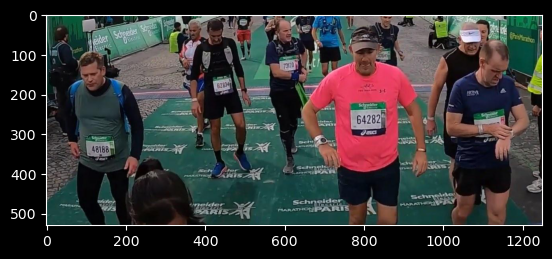

In [2]:
plt.imshow(img)

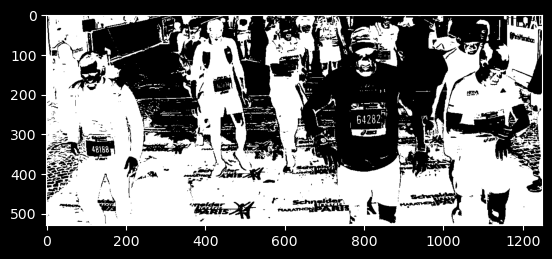

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
threshed = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# plt.imshow(gray, cmap='gray')
# bh = cv2.morphologyEx(threshed, cv2.MORPH_BLACKHAT, (1,1))
plt.imshow(threshed,cmap='gray')

In [4]:
from utils import forward_passer, box_extractor
from imutils.object_detection import non_max_suppression

def resize_image(image, width, height):
    """
    Re-sizes image to given width & height
    :param image: image to resize
    :param width: new width
    :param height: new height
    :return: modified image, ratio of new & old height and width
    """
    h, w = image.shape[:2]

    ratio_w = w / width
    ratio_h = h / height

    image = cv2.resize(image, (width, height))

    return image, ratio_w, ratio_h

def find_text(image, width, height, min_confidence=0.5):
    detector = "frozen_east_text_detection.pb"

    # reading in image
    orig_image = image.copy()

    # resizing image
    image, ratio_w, ratio_h = resize_image(image, width, height)

    # layers used for ROI recognition
    layer_names = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

    # pre-loading the frozen graph
    print("[INFO] loading the detector...")
    net = cv2.dnn.readNet(detector)

    # getting results from the model
    scores, geometry = forward_passer(net, image, layers=layer_names)

    # decoding results from the model
    rectangles, confidences = box_extractor(scores, geometry, min_confidence)

    # applying non-max suppression to get boxes depicting text regions
    boxes = non_max_suppression(np.array(rectangles), probs=confidences)
    rois = []
    for (start_x, start_y, end_x, end_y) in boxes:
        start_x = int(start_x * ratio_w) - 20
        start_y = int(start_y * ratio_h) - 20
        end_x = int(end_x * ratio_w) + 20
        end_y = int(end_y * ratio_h) + 20
        roi = (start_x, start_y, end_x - start_x, end_y - start_y)
        rois.append(roi)
        cv2.rectangle(orig_image, (start_x, start_y), (end_x, end_y), (255, 0, 0), 2)

    return rois, orig_image



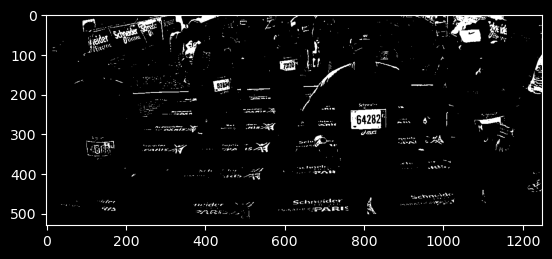

In [10]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

threshold = 150
threshed_for_morph = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)[1]
plt.imshow(threshed_for_morph,cmap='gray')

In [ ]:
threshed_2 = threshed[..., np.newaxis]
eroded = cv2.morphologyEx(threshed, cv2.MORPH_ERODE, (10, 10), iterations=10)
border = 100
eroded[:border, :] = 0
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
mask =  cv2.morphologyEx(eroded, op=cv2.MORPH_CLOSE, kernel=kernel, iterations=2)
plt.imshow(mask, cmap='gray')

In [ ]:
resized = cv2.resize(img, None, fx=0.5, fy=0.5)

threshold = 100
threshed = (resized > threshold).all(axis=2)
threshed = threshed * np.uint8(255)
threshed_2 = threshed[..., np.newaxis]
eroded = cv2.morphologyEx(threshed, cv2.MORPH_ERODE, (10, 10), iterations=10)
border = 100
eroded[:border, :] = 0
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
mask =  cv2.morphologyEx(eroded, op=cv2.MORPH_CLOSE, kernel=kernel, iterations=2)

gray = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)
threshed = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# threshed = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV )[1]
img_masked = np.bitwise_and(threshed, mask)
# plt.imshow(img_masked)
threshed_rgb = cv2.cvtColor(img_masked, cv2.COLOR_GRAY2RGB)
rois, res = find_text(threshed_rgb, 640, 320, 0.9)
plt.imshow(res)


In [ ]:
plt.imshow(threshed, cmap='gray')
threshed = np.bitwise_not(threshed)